In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/learn-together/sample_submission.csv
/kaggle/input/learn-together/test.csv
/kaggle/input/learn-together/train.csv


In [2]:
train = pd.read_csv('/kaggle/input/learn-together/train.csv', index_col = 'Id')
test = pd.read_csv('/kaggle/input/learn-together/test.csv', index_col='Id')

In [3]:
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


### Feature Engineering

#### Aspect Binning

In [4]:
Aspect = ['N', 'E', 'S', 'W']

def get_aspect_direction(aspect):
    if(aspect < 45):
        direction = Aspect[0]
    elif(aspect > 45 and aspect < 135):
        direction = Aspect[1]
    elif(aspect > 135 and aspect < 225):    
        direction = Aspect[2]
    elif(aspect > 225 and aspect < 315):    
        direction = Aspect[3]
    else:
        direction = Aspect[0]
    
    return direction
    
def feat_Aspect_Dir(df):
    df['Aspect_Dir'] = df.Aspect.apply(lambda x: get_aspect_direction(float(x))) 
    dummies = pd.get_dummies(df['Aspect_Dir'])
    for row_name in Aspect:
        df[row_name] = dummies[row_name]
        
    return df

train = feat_Aspect_Dir(train)
test = feat_Aspect_Dir(test)

#### Soil_Type

In [5]:
Soil_Type_list = []
for i in range(1,41):
    soiltype = f'Soil_Type{i}'
    Soil_Type_list.append(soiltype)

#put soil type for each example in one column 'Soil_Type'
def feat_soil_type(df):
    df['Soil_Type'] = 0
    for i, soiltype in enumerate(Soil_Type_list):
        df['Soil_Type'] = df['Soil_Type'] + (i+1)*df[soiltype] 
    return df

train = feat_soil_type(train)
test = feat_soil_type(test)

#### Distance to Hydrology

In [6]:
def feat_dist_to_hydrology(df):
    hd = 'Horizontal_Distance_To_Hydrology'
    vd = 'Vertical_Distance_To_Hydrology'
    df['Euclidean_Distance_To_Hydrology'] = np.sqrt(df[hd]**2 + df[vd]**2)
    return df

train = feat_dist_to_hydrology(train)
test = feat_dist_to_hydrology(test)

#### Slope to hydrology

In [7]:
def feat_slope_to_hydrology(df):
    df['Slope_to_hydrology'] = [0 if dist<0 else 1 for dist in df['Vertical_Distance_To_Hydrology']]
    return df

train = feat_slope_to_hydrology(train)
tests = feat_slope_to_hydrology(test)

#### Stone level

In [8]:
ext_stoney = [1,2,9,18,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40]   #extremely stoney + very stoney
stoney = [6,12]
rubly = [3,4,5,10,11,13]


def get_stone_level(i):
    switcher={
                1:1, 2:1, 9:1, 18:1, 23:1, 24:1,
                25:1, 26:1, 27:1, 28:1, 29:1, 30:1,
                31:1, 32:1, 33:1, 34:1, 36:1, 37:1,
                38:1, 39:1, 40:1,
        
                6:2, 12:2,
        
                3:3, 4:3, 5:3, 10:3, 11:3, 13:3
             }
    return switcher.get(i,0)

def feat_stone_level(df):
    df['stone_level'] = 0
    df['stone_level'] = [get_stone_level(soiltype) for soiltype in df['Soil_Type']]
    return df

train = feat_stone_level(train)
test = feat_stone_level(test)

#### Distance_To_Fire_Points AND Distance_To_Roadways  

In [9]:
import math

def feat_dist_Fire_Points_AND_Roadways(df):
    slope_in_rad = [math.radians(s) for s in df['Slope']]
    cosine_slope = np.cos(slope_in_rad)
    df['Distance_To_Fire_Points'] = df['Horizontal_Distance_To_Fire_Points']*cosine_slope
    df['Distance_To_Roadways'] = df['Horizontal_Distance_To_Roadways']*cosine_slope
    return df

train = feat_dist_Fire_Points_AND_Roadways(train)
test = feat_dist_Fire_Points_AND_Roadways(test)

#### Hillshade_Average

In [10]:
def feat_hillshade(df):
    df['shade_diff_9_noon'] = df['Hillshade_9am'] - df['Hillshade_Noon']
    df['shade_diff_noon_3'] = df['Hillshade_Noon'] - df['Hillshade_3pm']
    df['shade_diff_9_3'] = df['Hillshade_9am'] - df['Hillshade_3pm']
    df['shade_average'] = (df['Hillshade_9am'] + df['Hillshade_Noon'] + df['Hillshade_3pm'])/3
    return df

train = feat_hillshade(train)
test = feat_hillshade(test)

#### WildernessArea vs CoverType

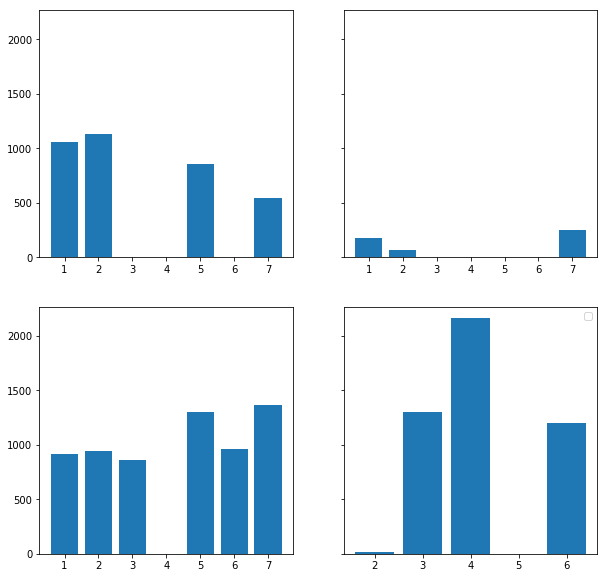

In [12]:
wa1 = train[train['Wilderness_Area1']==1]
wa1_data = wa1['Cover_Type'].value_counts()
wa2 = train[train['Wilderness_Area2']==1]
wa2_data = wa2['Cover_Type'].value_counts()
wa3 = train[train['Wilderness_Area3']==1]
wa3_data = wa3['Cover_Type'].value_counts()
wa4 = train[train['Wilderness_Area4']==1]
wa4_data = wa4['Cover_Type'].value_counts()

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True)
axes[0][0].bar(wa1_data.index.values, wa1_data, label='Area 1')
axes[0][1].bar(wa2_data.index.values, wa2_data)
axes[1][0].bar(wa3_data.index.values, wa3_data)
axes[1][1].bar(wa4_data.index.values, wa4_data)
plt.legend()

def feat_WACT(df):
    df['WACT_1257'] = df['Wilderness_Area1'] + df['Wilderness_Area3']
    df['WACT_36'] = df['Wilderness_Area3'] + df['Wilderness_Area4']
    return df

train = feat_WACT(train)
test = feat_WACT(test)

### Features from kernel : 
https://www.kaggle.com/evimarp/top-7-roosevelt-national-forest-competition/#Feautures-selection

In [13]:
def elevation(df):
    df['ElevationHydro'] = df['Elevation'] - 0.1 * df['Euclidean_Distance_To_Hydrology']
    return df

train = elevation(train)
test = elevation(test)


def elevationV(df):
    df['ElevationV'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']
    return df

train = elevationV(train)
test = elevationV(test)


def elevationH(df):
    df['ElevationH'] = df['Elevation'] - 0.19 * df['Horizontal_Distance_To_Hydrology']
    return df

train = elevationH(train)
test = elevationH(test)

def feat_distance_mean(df):
    df['distance_mean'] = (df['Euclidean_Distance_To_Hydrology'] + df['Distance_To_Fire_Points'] + df['Distance_To_Roadways'])/3
    return df

train = feat_distance_mean(train)
test = feat_distance_mean(test)

def feat_distance_fire_hydro(df):
    df['distance_fire_hydro'] = df['Euclidean_Distance_To_Hydrology'] + df['Distance_To_Fire_Points']
    return df

train = feat_distance_fire_hydro(train)
test = feat_distance_fire_hydro(test)

def feat_distance_fire_road(df):
    df['distance_fire_road'] = df['Distance_To_Roadways'] + df['Distance_To_Fire_Points']
    return df

train = feat_distance_fire_road(train)
test = feat_distance_fire_road(test)

def feat_distance_hydro_road(df):
    df['distance_hydro_road'] = df['Distance_To_Roadways'] + df['Euclidean_Distance_To_Hydrology']
    return df

train = feat_distance_hydro_road(train)
test = feat_distance_hydro_road(test)
    

#### Kernel features

In [14]:
def kernel_features(df):
    df['Elevation2'] = df['Elevation']**2
    df['ElevationLog'] = np.log1p(df['Elevation'])
    return df

train = kernel_features(train)
test = kernel_features(test)


def degree(df):
    df['Aspect_sin'] = np.sin(df.Aspect)
    df['Aspect_cos'] = np.cos(df.Aspect)
    df['Slope_sin'] = np.sin(df.Slope)
    df['Slope_cos'] = np.cos(df.Slope)
    
    
    return df

train = degree(train)
test = degree(test)


#### Features based on : Soil Type

In [15]:
def feat_STCT(df):
    df['STCT_125'] = df['Soil_Type29'] + df['Soil_Type30'] + df['Soil_Type31'] + df['Soil_Type32'] 
    + df['Soil_Type33'] 
    
    df['STCT_7'] = df['Soil_Type38'] + df['Soil_Type39'] + df['Soil_Type40']
    df['STCT_4'] = df['Soil_Type3'] + df['Soil_Type17']
    df['STCT_3'] = df['Soil_Type4'] + df['Soil_Type10']
    df['STCT_1'] = df['Soil_Type22'] + df['Soil_Type23'] + df['Soil_Type24']
    
    return df

train = feat_STCT(train)
test = feat_STCT(test)

#### Features based on : Rock complex, Family

In [16]:
# Rock Type

rock_outcrop = [1, 3, 4, 5, 6, 10, 27, 28, 32, 33, 35, 37]
rock_land = [11, 12, 13, 30, 34, 36, 40]

def get_rock_type(i):
    switcher={
                1:1, 3:1, 4:1, 5:1, 6:1, 10:1,
                27:1, 28:1, 32:1, 33:1, 35:1, 37:1,
        
                11:2, 12:2, 13:2, 30:2, 34:2, 36:2, 40:2
             }
    return switcher.get(i,0)

train['rock_type'] = [get_rock_type(soiltype) for soiltype in train['Soil_Type']]
test['rock_type'] = [get_rock_type(soiltype) for soiltype in test['Soil_Type']]


# Family

leighan_family = [21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 38, 39]

def get_family(i):
    switcher={
                21:1, 22:1, 23:1, 24:1, 25:1, 27:1,
                28:1, 31:2, 32:1, 33:1, 38:1, 39:1
             }
    return switcher.get(i,0)

train['family'] = [get_family(soiltype) for soiltype in train['Soil_Type']]
test['family'] = [get_family(soiltype) for soiltype in test['Soil_Type']]

#### Separate label from features

In [17]:
y = train['Cover_Type'].values.reshape(-1,1)
X = train.drop(['Cover_Type'], axis=1)

#### Drop unnecessary features 

In [18]:
# train = train.drop(Soil_Type_list, axis=1)

def drop_cols(df):
    cols_to_drop = ['Soil_Type', 'Soil_Type7', 'Soil_Type15', 
                    'Soil_Type8', 'Soil_Type25',
                    'Soil_Type36', 'Soil_Type28', 'Soil_Type27', 'Soil_Type9',
                    'Soil_Type34',
                    'Soil_Type14', 'Soil_Type19', 'Soil_Type21', 'Soil_Type26',
                    'Aspect_Dir'
                    #'Soil_Type1', 'Soil_Type16', 'Soil_Type18', 'Soil_Type37'
                   ]
    df = df.drop(cols_to_drop, axis=1)
    return df

X = drop_cols(X)
test = drop_cols(test)

#### Check final features

In [19]:
print(len(X.dtypes))
print(len(test.dtypes))

76
76


### Random Forest Classifier

In [21]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, 
                              GradientBoostingClassifier, RandomForestClassifier)


random_state = 6
n_jobs = -1

all_train_scores = []
all_test_scores = []

# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=140,
                                 n_jobs=n_jobs,
                                 random_state=random_state)

cv_score = cross_validate(rf_clf, X, y, cv=10, return_train_score=True)
mean_train_score = np.mean(cv_score['train_score'])
mean_test_score = np.mean(cv_score['test_score'])

print('Mean Train Score :', mean_train_score)
print('Mean Test Score :', mean_test_score)

all_train_scores.append(mean_train_score)
all_test_scores.append(mean_test_score)
#rf_clf.fit(X, y)

Mean Train Score : 1.0
Mean Test Score : 0.7919973544973544


### XGBoost Classifier

In [ ]:
# from xgboost import XGBClassifier

# model = XGBClassifier()
# model.fit(X_train, y_train)

### ExtraTreeClassifier

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.model_selection import cross_validate
# ex_clf =  ExtraTreesClassifier(
#                                max_depth=35, 
#                                n_estimators=400, n_jobs=-1,
#                                oob_score=False, random_state=6, 
#                                warm_start=True)

# # cv_score = cross_validate(ex_clf, X, y, cv=10, return_train_score=True)
# # mean_train_score = np.mean(cv_score['train_score'])
# # mean_test_score = np.mean(cv_score['test_score'])

# # print('Mean Train Score :', mean_train_score)
# # print('Mean Test Score :', mean_test_score)
# ex_clf.fit(X,y)

### Feature Importance

In [ ]:
rf_clf.fit(X, y)
# print(clf.get_params())
feat_importances = [round(fi, 4) for fi in rf_clf.feature_importances_]
# l = list(zip(X.columns, feat_importances))
# s = sorted(l, key = lambda x: x[1], reverse=True)

importances = pd.DataFrame({'Features': X.columns,
                          'Importances' : feat_importances})
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)
fig = plt.figure(figsize=(15, 5))
sns.barplot(x='Features', y='Importances', data=importances)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# #Boruta feature selection
# from boruta import BorutaPy


In [ ]:
test.head()

In [ ]:
preds_test = ex_clf.predict(test)

In [ ]:
import csv
test_id = test.index
output = pd.DataFrame({
        "Id": test_id,
        "Cover_Type": preds_test})
output.to_csv('submission.csv', index=False)